#Applied Machine Learning Course - Module 3
 Notebook
- Matthew Block  
- 06 November 2025

### Introduction
This notebook explores a classic machine learning problem: predicting passenger survival on the RMS Titanic. The sinking of the Titanic is one of the most infamous shipwrecks in history, and the dataset of its passengers provides a case study for classification modeling.

The goal of this project is to build a model that can predict whether a passenger survived based on features such as their age, sex, passenger class, and fare paid. We will use the Titanic dataset, available through the Seaborn library, which contains demographic and travel information for 891 passengers.

Through data exploration, feature engineering, and model training, we will analyze the factors that contributed to survival and evaluate the performance of our classification model.

In [1]:
# imports
import seaborn as sns
from pandas.plotting import scatter_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

## 1. Import & Inspect Data

In [2]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [3]:
print(titanic.head(10))
print(titanic.isnull().sum())
print(titanic.describe())

   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0         0       3    male  22.0      1      0   7.2500        S   Third   
1         1       1  female  38.0      1      0  71.2833        C   First   
2         1       3  female  26.0      0      0   7.9250        S   Third   
3         1       1  female  35.0      1      0  53.1000        S   First   
4         0       3    male  35.0      0      0   8.0500        S   Third   
5         0       3    male   NaN      0      0   8.4583        Q   Third   
6         0       1    male  54.0      0      0  51.8625        S   First   
7         0       3    male   2.0      3      1  21.0750        S   Third   
8         1       3  female  27.0      0      2  11.1333        S   Third   
9         1       2  female  14.0      1      0  30.0708        C  Second   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes

In [4]:
print(titanic.corr(numeric_only=True))

            survived    pclass       age     sibsp     parch      fare  \
survived    1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307   
pclass     -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500   
age        -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067   
sibsp      -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651   
parch       0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225   
fare        0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000   
adult_male -0.557080  0.094035  0.280328 -0.253586 -0.349943 -0.182024   
alone      -0.203367  0.135207  0.198270 -0.584471 -0.583398 -0.271832   

            adult_male     alone  
survived     -0.557080 -0.203367  
pclass        0.094035  0.135207  
age           0.280328  0.198270  
sibsp        -0.253586 -0.584471  
parch        -0.349943 -0.583398  
fare         -0.182024 -0.271832  
adult_male    1.000000  0.404744  
alone         0.404744  1.000000  


In [5]:
# Calculate the correlation matrix
corr_matrix = titanic.corr(numeric_only=True)

# Unstack the matrix to get a series of correlation pairs
corr_pairs = corr_matrix.stack()

# Remove self-correlations (e.g., survived vs. survived)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Create a DataFrame from the series and sort it
sorted_corr = corr_pairs.to_frame('correlation').sort_values('correlation', ascending=False)

# The list contains duplicates (e.g., parch/sibsp and sibsp/parch), so we'll drop them
# by taking every other row.
unique_sorted_corr = sorted_corr.iloc[::2]

print("Sorted Feature Correlations:")
print(unique_sorted_corr)


Sorted Feature Correlations:
                       correlation
parch      sibsp          0.414838
alone      adult_male     0.404744
age        adult_male     0.280328
fare       survived       0.257307
parch      fare           0.216225
age        alone          0.198270
fare       sibsp          0.159651
alone      pclass         0.135207
age        fare           0.096067
adult_male pclass         0.094035
sibsp      pclass         0.083081
survived   parch          0.081629
pclass     parch          0.018443
survived   sibsp         -0.035322
age        survived      -0.077221
adult_male fare          -0.182024
parch      age           -0.189119
survived   alone         -0.203367
sibsp      adult_male    -0.253586
fare       alone         -0.271832
age        sibsp         -0.308247
pclass     survived      -0.338481
adult_male parch         -0.349943
pclass     age           -0.369226
fare       pclass        -0.549500
survived   adult_male    -0.557080
alone      parch         -

In [6]:
# Calculate and display the minimum, median, and maximum for 'age'
age_stats = titanic['age'].agg(['min', 'median', 'max'])

print("Age Statistics:")
print(age_stats)


Age Statistics:
min        0.42
median    28.00
max       80.00
Name: age, dtype: float64


### Reflection 1
1) How many data instances are there?
   1) 891
2) How many features are there?
   1) 15
3) What are the names?
   1) survived         0
   2) pclass           0
   3) sex              0
   4) age            177
   5) sibsp            0
   6) parch            0
   7) fare             0
   8) embarked         2
   9) class            0
   10) who              0
   11) adult_male       0
   12) deck           688
   13) embark_town      2
   14) alive            0
   15) alone            0
4) Are there any missing values?
   1) Yes, numbers of missing values are identified in line with Question 3 answers immediately above
5) Are there any non-numeric features?
   1) Yes
6) Are the data instances sorted on any of the attributes?
   1) Appears to be NO
7) What are the units of age?
   1) Looks like years
8) What are the minimum, median and max age?
   1) min        0.42
   2) median    28.00
   3) max       80.00
9)  What two different features have the highest correlation?
    1)  The strongest correlation is a negative correlation between "alone" and "sibsp"
10)  Are there any categorical features that might be useful for prediction?
     1)  Knowing a bit about how people got stuck on or got off the Titanic, both class and deck might be useful in predicting survival.

## 2. Exploration & Preparation
  
### 2.1 Explore Data Patterns and Distributions

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='fare', ylabel='age'>,
        <Axes: xlabel='pclass', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='fare'>,
        <Axes: xlabel='fare', ylabel='fare'>,
        <Axes: xlabel='pclass', ylabel='fare'>],
       [<Axes: xlabel='age', ylabel='pclass'>,
        <Axes: xlabel='fare', ylabel='pclass'>,
        <Axes: xlabel='pclass', ylabel='pclass'>]], dtype=object)

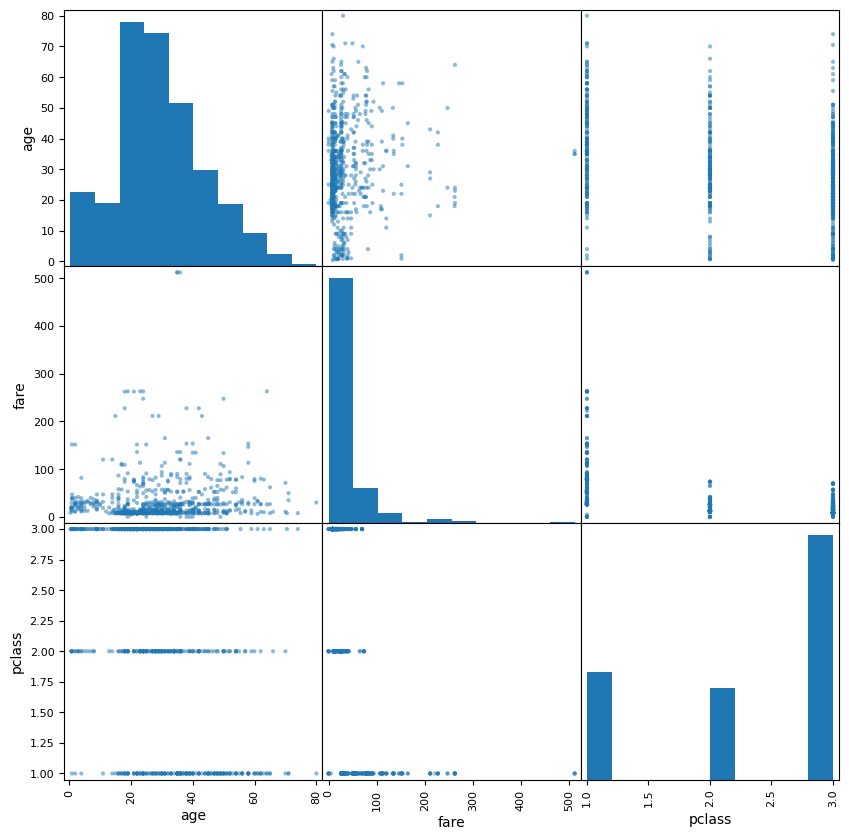

In [7]:
attributes = ['age', 'fare', 'pclass']
scatter_matrix(titanic[attributes], figsize=(10, 10))

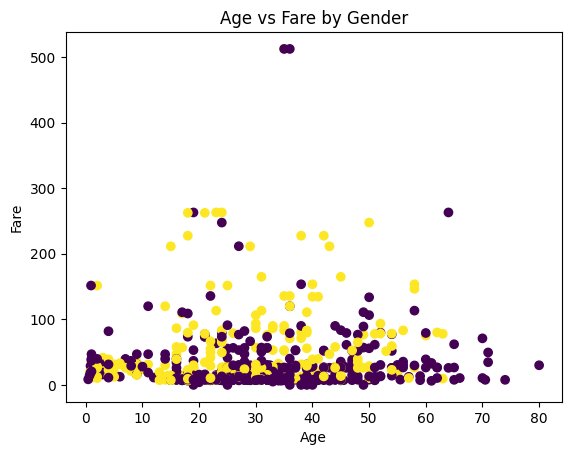

In [8]:
plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.show()

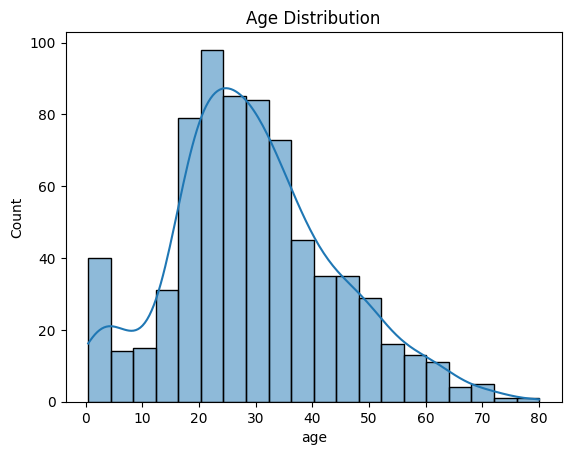

In [9]:
sns.histplot(titanic['age'], kde=True)
plt.title('Age Distribution')
plt.show()

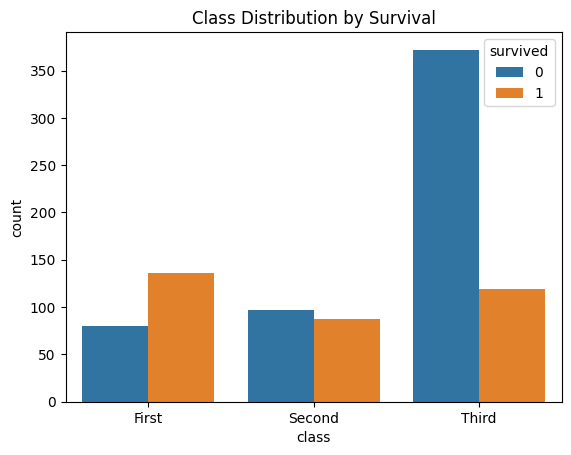

In [10]:
sns.countplot(x='class', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()

### Reflection 2.1
- What patterns or anomalies do you notice?
  - Likelihood of survival seems heavily correlated to passenger class.
  - Classes seem to skew older as they go up from third to first, and fare skews higher with class (as we would expect)
- Do any features stand out as potential predictors?
  - Class is probably a strong predictor of survival.
- Are there any visible class imbalances?
  - The vast majority of passengers were in Third Class.

### 2.2 Handle Missing Values & Clean Data

In [11]:
# impute missing values for age using the median:
# titanic['age'].fillna(titanic['age'].median(), inplace=True)  ---Changed
titanic.fillna({'age': np.median(titanic['age'])}, inplace=True)

# replace missing values for embark_town with mode value:
# titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True) ---Changed
titanic.fillna({'embark_town': titanic['embark_town'].mode()[0]}, inplace=True)

print(titanic.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64


### 2.3 Feature Engineering

In [12]:
# Create a new feature: Family size
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Convert categorical data to numeric:
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Create a binary feature for 'alone':
titanic['alone'] = titanic['alone'].astype(int)


### Reflection 2.3
- Why might family size be a useful feature for predicting survival?
  - It's possible people with families were able to help their family members do what was needed to escape.
- Why convert categorical data to numeric?
  - Most machine learning algorithms need numerical data to work

## 3. Feature Selection & Justification

- Select two or more input features (numerical for regression, numerical and/or categorical for classification)
  - pclass
  - fare
  - adult_male
  - alone
- Select a target variable (as applicable)
  - Survived
    - We can see how individual features correlate to survvial pretty easily, but this process may help us better understand what groupings of features led to survival (potentially in an unexpected way).


In [13]:
# Prepare feature matrix X and target vector y
X = titanic[['pclass', 'fare', 'adult_male', 'alone']]
y = titanic['survived']

### Reflection 3:
- Why are these features selected?
  - These features had some of the higher correlations to survival from our initial exploration.
- Are there any features that are likely to be highly predictive of survival?
  - All of them should, but adult_male is the highest based on correlation. The combination of adult_male and pclass is likely even higher.

## 4. Split Testing
Split the data into training and test sets using train_test_split first and StratifiedShuffleSplit second. Compare.

In [14]:
# train_test_split returns four objects when splitting X and y:
# X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print('X_train size:', len(X_train))
print('X_test size:', len(X_test))
print('y_train size:', len(y_train))
print('y_test size:', len(y_test))

X_train size: 712
X_test size: 179
y_train size: 712
y_test size: 179


In [15]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    train_set = X.iloc[train_indices]
    test_set = X.iloc[test_indices]

print('Train size:', len(train_set))
print('Test size:', len(test_set))

Train size: 712
Test size: 179


In [16]:
# Compare
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Strat Train Set Class Distribution:\n", train_set['pclass'].value_counts(normalize=True))
print("Strat Test Set Class Distribution:\n", test_set['pclass'].value_counts(normalize=True))
print("Test Set Class Distribution:\n", X_train['pclass'].value_counts(normalize=True))
print("Test Set Class Distribution:\n", X_test['pclass'].value_counts(normalize=True))
# print("Test Set Class Distribution:\n", y_train.value_counts(normalize=True))
# print("Test Set Class Distribution:\n", y_test.value_counts(normalize=True))

Original Class Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Strat Train Set Class Distribution:
 pclass
3    0.561798
1    0.227528
2    0.210674
Name: proportion, dtype: float64
Strat Test Set Class Distribution:
 pclass
3    0.508380
1    0.301676
2    0.189944
Name: proportion, dtype: float64
Test Set Class Distribution:
 pclass
3    0.557584
1    0.233146
2    0.209270
Name: proportion, dtype: float64
Test Set Class Distribution:
 pclass
3    0.525140
1    0.279330
2    0.195531
Name: proportion, dtype: float64


### Reflection 4
- Why might stratification improve model performance?
  - Without stratification, a random split might result in one set having disproportionately more examples of a certain class, which can lead to:
    - Poor generalization
    - Misleading performance metrics
    - Overfitting to dominant classes
- How close are the training and test distributions to the original dataset?
  - Not wildly different, but not super close either. Within 20%ish.
- Which split method produced better class balance?
  - The stratified method produced slightly better balance on the training set.

## Module 3
As suggested in the course instructions, this notebook was started as a copy of the notebook from Module 2. Some of the entries above have been updated as necessary. The work below is exclusive to Module 3 and will be noted with "3-" preferencing the section numbers.

### 3-2. Data Exploration and Preparation


#### 3-2.1 Handle Missing Values and Clean Data

In [17]:
# Impute missing values for age using the median:
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

# Fill in missing values for embark_town using the mode:
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)

#### 3-2.2 Feature Engineering
Create new features:

    Add family_size - number of family members on board. Count sibsp (number of siblings or spouses on board), parch (number of parents or children on board), and 1 to count the individual.

    Convert categorical "sex" (male/female) to numeric binary (0 or 1)
        male =0, female=1
    Convert categorical "embarked" to numeric
        "C" (Cherboug) = 0
        "Q" (Queenstown) = 1
        "S" (Southampton) = 2
    Binary feature - convert "alone" to numeric binary (0 or 1)
        alone = 1, 0 = not alone

In [18]:
# Create new feature
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Map categories to numeric values
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)

### 3-3 Feature Selection and Justification
#### 3-3.1 Choose features and target
Select two or more input features (numerical for regression, numerical and/or categorical for classification)  
- pclass
- fare
- adult_male
- family_size  
Use survived as the target.  

---


We will do three input cases:


#### 3-3.2 Define X (features) and y (target)

In [19]:
# Case 1: Feature = pclass
# --------------------------------------------------------------------------
# Select the feature as input
X1 = titanic[['pclass']]

# Select 'survived' as the target for the same rows
y1 = titanic['survived']

# --------------------------------------------------------------------------
# Case 2: Feature = fare (drop if na or not available)
# --------------------------------------------------------------------------
# Select the feature 'fare', but drop rows where fare is missing
X2 = titanic[['fare']].dropna()

# Select the matching 'survived' values using the same index
y2 = titanic.loc[X2.index, 'survived']

# --------------------------------------------------------------------------
# Case 3: Features = Age + Family Size (drop if na or not available)
# --------------------------------------------------------------------------
# Select 'age' and 'family_size', and drop rows where missing (na)
X3 = titanic[['pclass', 'fare', 'adult_male', 'family_size']].dropna()

# Select the corresponding 'survived' values for those rows
y3 = titanic.loc[X3.index, 'survived']


#### Reflection 3-3:
Why are these features selected?
- They were selected based on a combination of their correlation values in the EDA phase, as well as some historical domain knowledge of rescue operations from the Titanic crash.  

Are there features that are likely to be highly predictive of survival?
- Yes, these should.

### 3-4 Train a Classification Model (Decision Tree)
#### 3-4.1 Split the Data

In [21]:
# Case 1: Feature = pclass
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):

    X1_train = X1.iloc[train_idx1]
    X1_test  = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test  = y1.iloc[test_idx1]

print('Case 1 - Passenger Class:')
print('Train size:', len(X1_train), '| Test size:', len(X1_test))

Case 1 - Passenger Class:
Train size: 712 | Test size: 179


In [22]:
# Case 2: Feature = fare
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test  = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test  = y2.iloc[test_idx2]

print('Case 2 - Fare:')
print('Train size:', len(X2_train), '| Test size:', len(X2_test))

Case 2 - Fare:
Train size: 712 | Test size: 179


In [23]:
# Case 3: Features = pclass + fare + adult_male + family_size
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test  = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test  = y3.iloc[test_idx3]

print('Case 3 - Combined Features:')
print('Train size:', len(X3_train), '| Test size:', len(X3_test))

Case 3 - Combined Features:
Train size: 712 | Test size: 179


#### 3-4.2 Create and Train Model (Decision Tree)


In [24]:
# CASE 1: Decision Tree using pclass
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

DecisionTreeClassifier()

In [26]:
# CASE 2: Decision Tree using fare
tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

DecisionTreeClassifier()

In [27]:
# CASE 3: Decision Tree using combined features
tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)

DecisionTreeClassifier()

#### 3-4.3 Predict and Evaluate Model Performance


In [28]:
# Predict on training data
y1_pred = tree_model1.predict(X1_train)
print("Results for Decision Tree on training data (Case 1 - pclass):")
print(classification_report(y1_train, y1_pred))

# Predict on test data
y1_test_pred = tree_model1.predict(X1_test)
print("Results for Decision Tree on test data (Case 1 - pclass):")
print(classification_report(y1_test, y1_test_pred))

Results for Decision Tree on training data (Case 1 - pclass):
              precision    recall  f1-score   support

           0       0.69      0.86      0.76       439
           1       0.62      0.37      0.46       273

    accuracy                           0.67       712
   macro avg       0.66      0.62      0.61       712
weighted avg       0.66      0.67      0.65       712

Results for Decision Tree on test data (Case 1 - pclass):
              precision    recall  f1-score   support

           0       0.73      0.83      0.77       110
           1       0.65      0.51      0.57        69

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.67       179
weighted avg       0.70      0.70      0.70       179



In [29]:
# Predict on training data
y2_pred = tree_model2.predict(X2_train)
print("Results for Decision Tree on training data (Case 2 - Fare):")
print(classification_report(y2_train, y2_pred))

# Predict on test data
y2_test_pred = tree_model2.predict(X2_test)
print("Results for Decision Tree on test data (Case 2 - Fare):")
print(classification_report(y2_test, y2_test_pred))

Results for Decision Tree on training data (Case 2 - Fare):
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       439
           1       0.90      0.59      0.71       273

    accuracy                           0.82       712
   macro avg       0.84      0.77      0.79       712
weighted avg       0.83      0.82      0.81       712

Results for Decision Tree on test data (Case 2 - Fare):
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       110
           1       0.58      0.48      0.52        69

    accuracy                           0.66       179
   macro avg       0.64      0.63      0.63       179
weighted avg       0.66      0.66      0.66       179



In [30]:
# Predict on training data
y3_pred = tree_model3.predict(X3_train)
print("Results for Decision Tree on training data (Case 3 - Combined Feature):")
print(classification_report(y3_train, y3_pred))

# Predict on test data
y3_test_pred = tree_model3.predict(X3_test)
print("Results for Decision Tree on test data (Case 3 - Combined Features):")
print(classification_report(y3_test, y3_test_pred))

Results for Decision Tree on training data (Case 3 - Combined Feature):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       439
           1       0.95      0.86      0.90       273

    accuracy                           0.93       712
   macro avg       0.93      0.91      0.92       712
weighted avg       0.93      0.93      0.93       712

Results for Decision Tree on test data (Case 3 - Combined Features):
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       110
           1       0.71      0.70      0.70        69

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



#### 3-4.4 Report Confusion Matrix (as a heatmap)

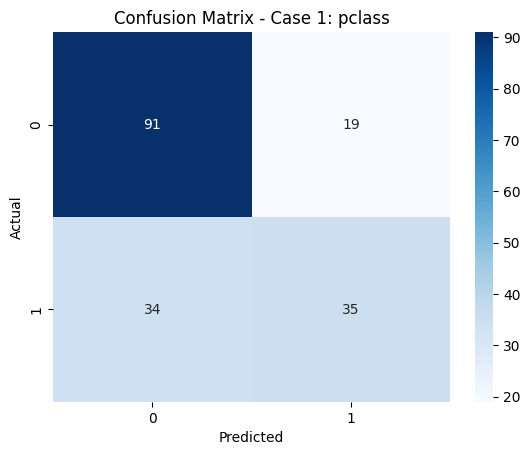

In [31]:
# Create confusion matrix for test predictions (Case 1)
cm1 = confusion_matrix(y1_test, y1_test_pred)

# Plot heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 1: pclass')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

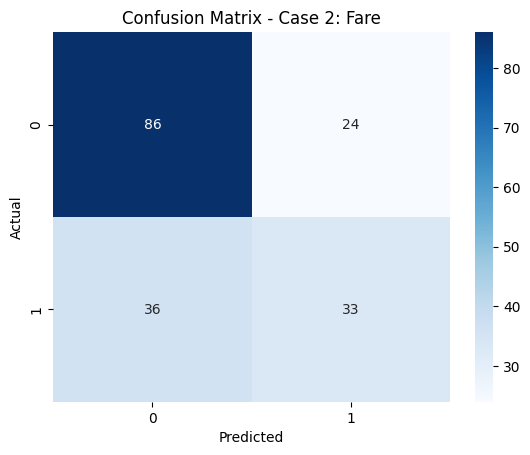

In [32]:
# Create confusion matrix for test predictions (Case 2)
cm2 = confusion_matrix(y2_test, y2_test_pred)

# Plot heatmap
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 2: Fare')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

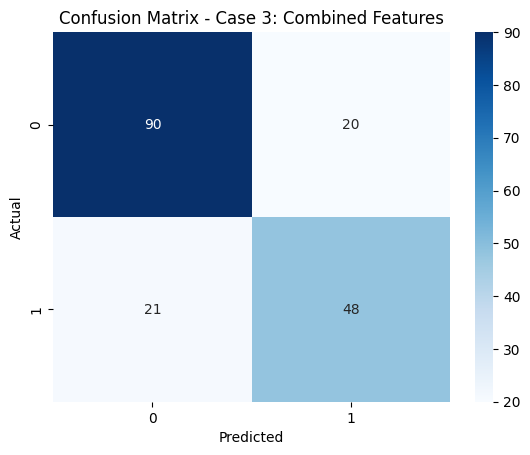

In [33]:
# Create confusion matrix for test predictions (Case 3)
cm3 = confusion_matrix(y3_test, y3_test_pred)

# Plot heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 3: Combined Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### 3-4.5 Report Decision Tree Plot


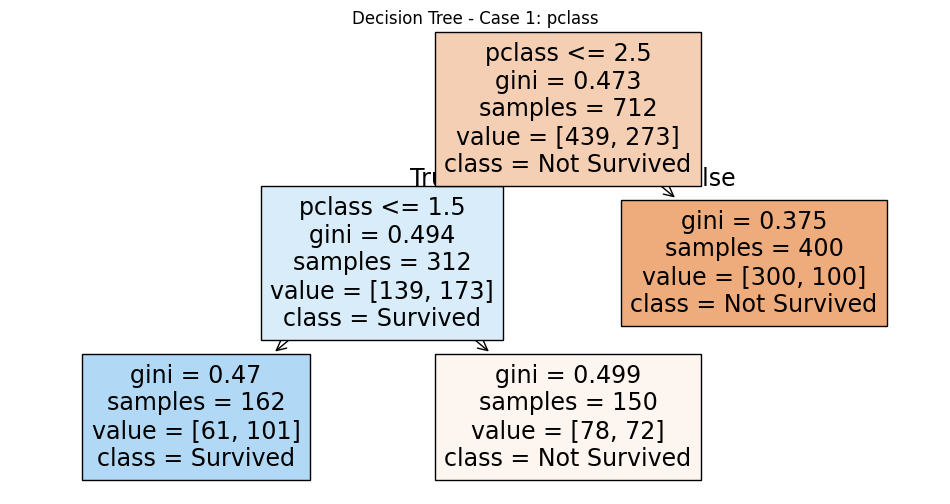

In [34]:
# Plot Decision Tree for Case 1
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model1,
          feature_names=X1.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 1: pclass")
plt.show()

# Save image
fig.savefig("tree_case1_pclass.png")

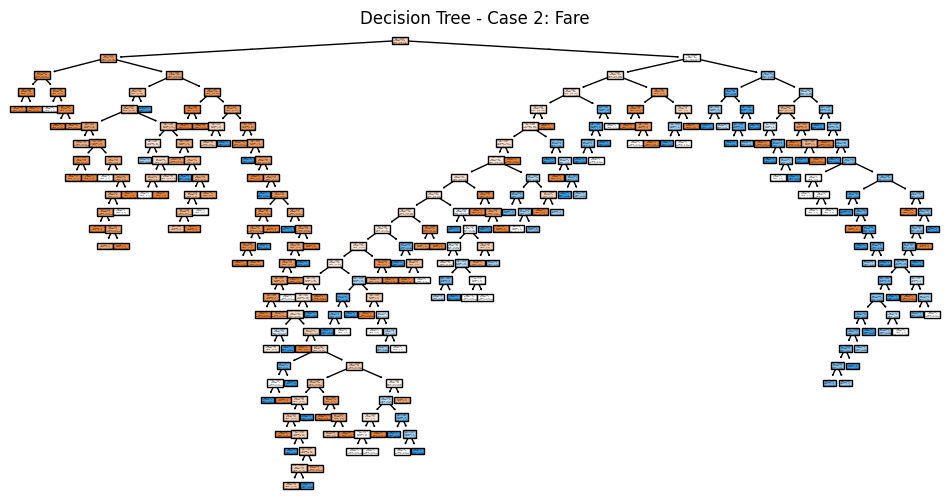

In [35]:
# Plot Decision Tree for Case 2
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model2,
          feature_names=X2.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 2: Fare")
plt.show()

# Save image
fig.savefig("tree_case2_fare.png")

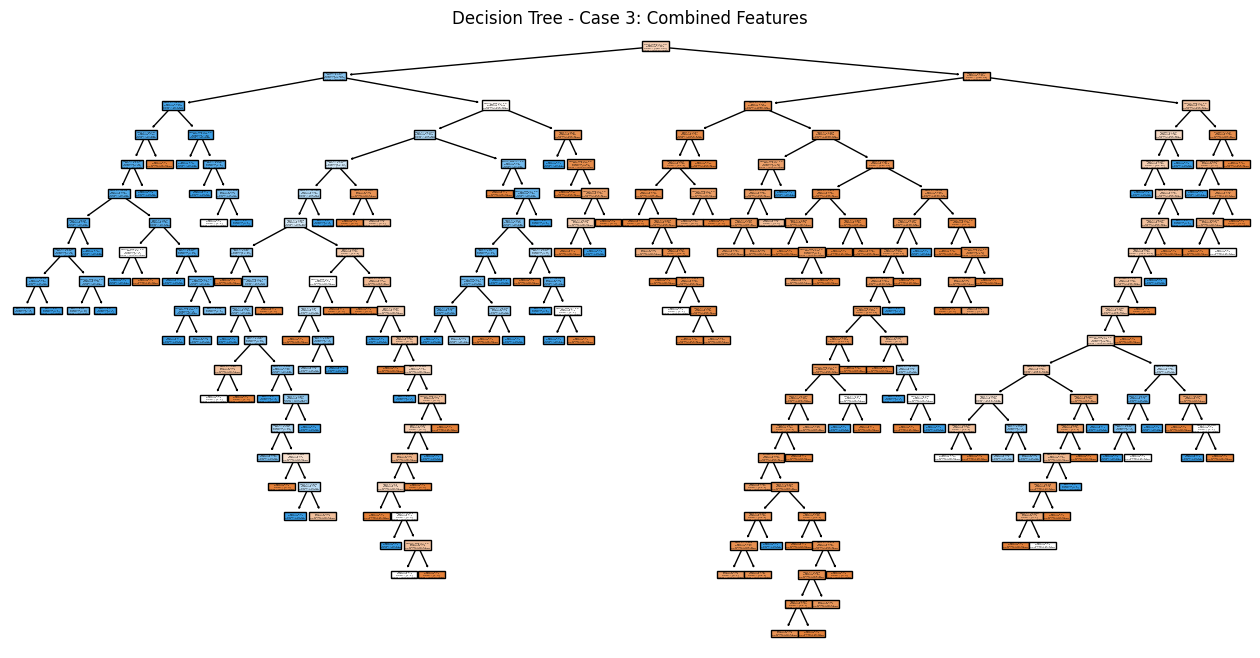

In [36]:
# Plot Decision Tree for Case 3
fig = plt.figure(figsize=(16, 8))
plot_tree(tree_model3,
          feature_names=X3.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 3: Combined Features")
plt.show()

# Save image
fig.savefig("tree_case3_combined.png")

### Reflection 3-4
Here is a summary of the results from the Decision Tree models for each case:

| Decision Tree | Case | Features | Accuracy (Test) | Precision (Test) | Recall (Test) | F1-Score (Test) | Notes |
|---|---|---|---|---|---|---|---|
| Decision Tree | Case 1 | pclass | 70.17% | 69% | 67% | 67% | - |
| Decision Tree | Case 2 | fare | 65.92% | 64% | 63% | 63% | - |
| Decision Tree | Case 3 | pclass + fare + adult_male + family_size | 77.09% | 76% | 76% | 76% | - |


  How well did the different cases perform?
  - They all performed fairly well, but the combined was notably better.

  Are there any surprising results?
  - Nothing too surprising.
  
  Which inputs worked better?
  - The combination clearly worked best, although I'm curious if removing any one of the four (most likely fare) would improve (or at least not harm) the predictive value.


### 3-5 Compare Alternative Models (SVC, NN)

In [38]:
# RBF Kernel (default) - same as calling SVC()
svc_model_rbf = SVC(kernel='rbf')
svc_model_rbf.fit(X_train, y_train)

# Linear Kernel
svc_model_linear = SVC(kernel='linear')
svc_model_linear.fit(X_train, y_train)

# Polynomial Kernel (e.g., with degree=3)
svc_model_poly = SVC(kernel='poly', degree=3)
svc_model_poly.fit(X_train, y_train)

# Sigmoid Kernel
svc_model_sigmoid = SVC(kernel='sigmoid')
svc_model_sigmoid.fit(X_train, y_train)

SVC(kernel='sigmoid')

#### 3-5.1 Train and Evaluate Model (SVC)

In [44]:
# CASE 1: SVC using 'pclass'
svc_model1 = SVC()
svc_model1.fit(X1_train, y1_train)
y1_svc_pred = svc_model1.predict(X1_test)
print("Results for SVC on test data (Case 1 - pclass):")
print(classification_report(y1_test, y1_svc_pred))

Results for SVC on test data (Case 1 - pclass):
              precision    recall  f1-score   support

           0       0.73      0.83      0.77       110
           1       0.65      0.51      0.57        69

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.67       179
weighted avg       0.70      0.70      0.70       179



In [47]:
# CASE 2: SVC using 'fare'
svc_model2 = SVC()
svc_model2.fit(X2_train, y2_train)
y2_svc_pred = svc_model2.predict(X2_test)
print("Results for SVC on test data (Case 2 - fare):")
print(classification_report(y2_test, y2_svc_pred))

Results for SVC on test data (Case 2 - fare):
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       110
           1       0.68      0.41      0.51        69

    accuracy                           0.70       179
   macro avg       0.69      0.64      0.65       179
weighted avg       0.70      0.70      0.68       179



In [48]:
# CASE 3: SVC using Combined Features
svc_model3 = SVC()
svc_model3.fit(X3_train, y3_train)
y3_svc_pred = svc_model3.predict(X3_test)
print("Results for SVC on test data (Case 3 - Combined Features):")
print(classification_report(y3_test, y3_svc_pred))

Results for SVC on test data (Case 3 - Combined Features):
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       110
           1       0.68      0.41      0.51        69

    accuracy                           0.70       179
   macro avg       0.69      0.64      0.65       179
weighted avg       0.70      0.70      0.68       179



#### 3-5.2 Visualize Support Vectors (1D Case 1 and 2D Case 3)


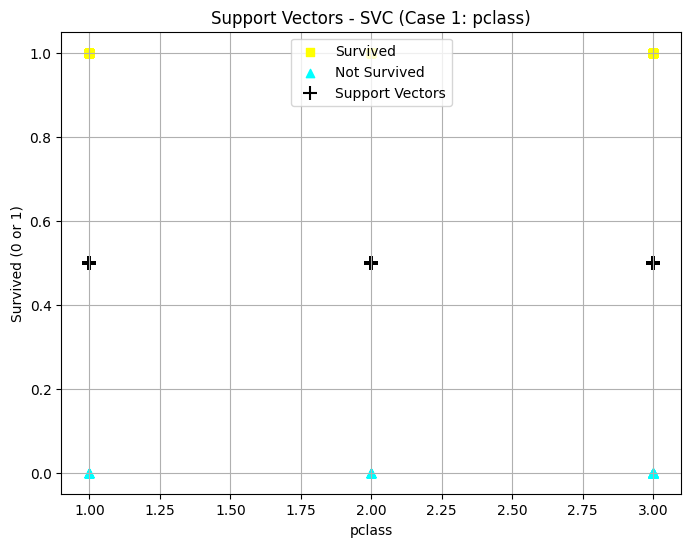

In [51]:
# Visualize support vectors for Case 1 (feature = 'pclass')

# Create groups based on survival
survived_pclass = X1_test.loc[y1_test == 1, 'pclass']
not_survived_pclass = X1_test.loc[y1_test == 0, 'pclass']

# Create scatter plot for survived and not survived
plt.figure(figsize=(8, 6))

plt.scatter(survived_pclass, y1_test.loc[y1_test == 1], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_pclass, y1_test.loc[y1_test == 0], c='cyan', marker='^', label='Not Survived')

# Overlay support vectors
# Check if the model has support_vectors_ (it may not if it failed to converge)
if hasattr(svc_model1, 'support_vectors_'):
    # Get the X-values of the support vectors (only one feature in Case 1
    support_x = svc_model1.support_vectors_[:, 0]  # First feature (alone)
    # Plot them using a fixed Y-value (0.5) to place them between classes visually
    # We use a larger size (s=100) and a plus symbol to make them stand out
    plt.scatter(support_x, [0.5] * len(support_x), c='black', marker='+', s=100, label='Support Vectors')

# Add labels and legend
plt.xlabel('pclass')
plt.ylabel('Survived (0 or 1)')
plt.title('Support Vectors - SVC (Case 1: pclass)')
plt.legend()
plt.grid(True)
plt.show()

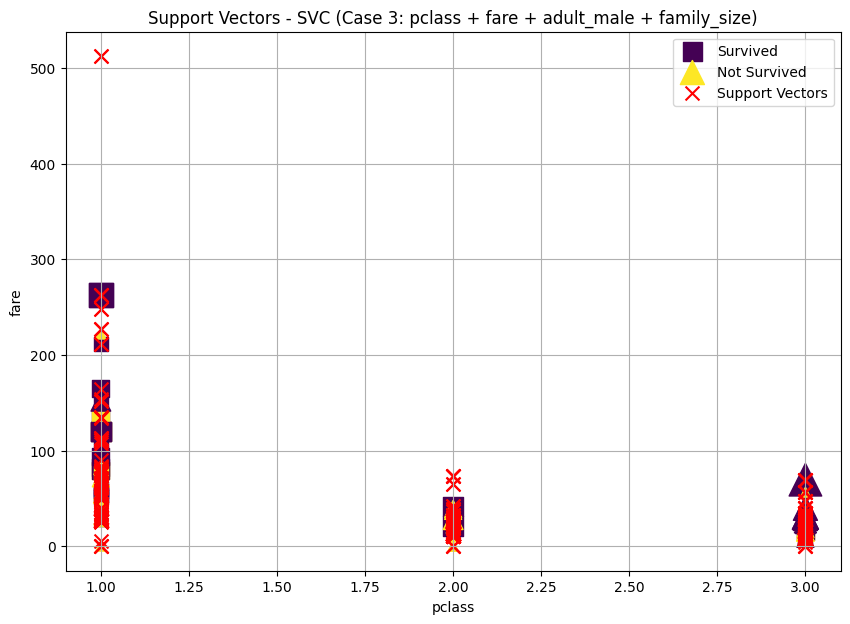

In [55]:
# Visualize support vectors for Case 3 (features = 'pclass', 'fare', 'adult_male', 'family_size')

# Create groups based on survival
survived = X3_test[y3_test == 1]
not_survived = X3_test[y3_test == 0]

# Create scatter plot
plt.figure(figsize=(10, 7))

# Plot survived
plt.scatter(survived['pclass'], survived['fare'], s=survived['family_size']*50, c=survived['adult_male'], cmap='viridis', marker='s', label='Survived')

# Plot not survived
plt.scatter(not_survived['pclass'], not_survived['fare'], s=not_survived['family_size']*50, c=not_survived['adult_male'], cmap='viridis', marker='^', label='Not Survived')


# Overlay support vectors (note: support vectors are based on the original features, so their representation
# in this multi-dimensional visualization might be complex)
if hasattr(svc_model3, 'support_vectors_'):
    support_vectors = svc_model3.support_vectors_
    # To plot support vectors, we need to decide how to represent 'adult_male' and 'family_size' for them.
    # For simplicity, let's plot them with a fixed size and color, or you might need to
    # get the original 'adult_male' and 'family_size' for these support vectors from the training data if needed.
    # For now, let's just plot their pclass and fare with a distinct marker.
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                c='red', marker='x', s=100, label='Support Vectors')


# Add labels, title, and legend
plt.xlabel('pclass')
plt.ylabel('fare')
plt.title('Support Vectors - SVC (Case 3: pclass + fare + adult_male + family_size)')
plt.legend()
plt.grid(True)
plt.show()